In [1]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy,copy
from myDataset import PalmNutriDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
sample_set = 'n17'
target = 'n'

plt.style.use('seaborn-whitegrid')

to_do = [('alex',       f'alexnet_{sample_set}/alex_{sample_set}'),
         ('mobilenet',  f'mobilenet_{sample_set}/mobilenet_{sample_set}'),
         ('resnext',    f'resnext_{sample_set}/resnext_{sample_set}')
         ]

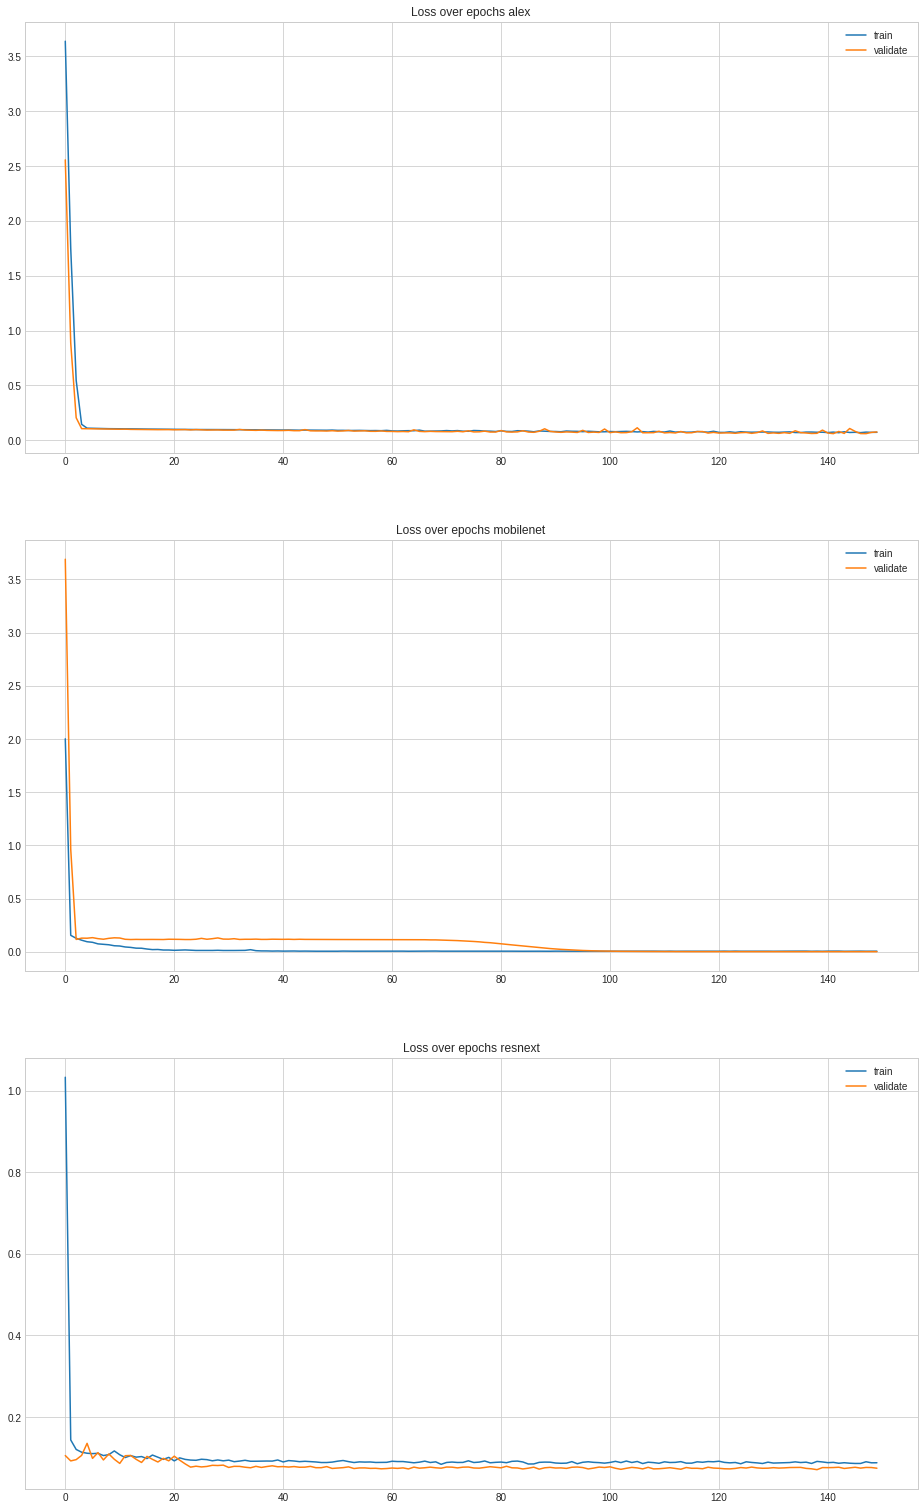

In [2]:
# Plot training result
fig,ax = plt.subplots(nrows=3, figsize=(16,9*3))
for index, (name, path) in enumerate(to_do):
    train_loss = pickle.load(open(f'{path}_train_loss.txt', 'rb'))
    val_loss = pickle.load(open(f'{path}_val_loss.txt', 'rb'))
    ax[index].set_title(f'Loss over epochs {name}')
    ax[index].plot(train_loss, label='train')
    ax[index].plot(val_loss, label='validate')
    ax[index].legend()
plt.show()

del(val_loss)
del(train_loss)

In [3]:
# the magic number
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

ground_truth = 'dataset/gt.csv'
full_dataset = PalmNutriDataset(ground_truth=ground_truth, img_dir='dataset', sample_set=sample_set,target=target)
full_dataset.transform = preprocess
print(len(full_dataset))

BATCH_SIZE=64
NUM_WORKERS=2
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)

1018


In [4]:
def load_model(name, pretrain=None):
    model = None
    if(name == 'alex'):
        model = models.alexnet()
        model.classifier[6] = torch.nn.Linear(in_features=4096,out_features=1,bias=True)
    elif(name == 'mobilenet'):
        model = models.mobilenet_v3_large()
        model.classifier[3] = torch.nn.Linear(in_features=1280,out_features=1,bias=True)
    elif(name == 'resnext'):
        model = models.resnext50_32x4d()
        model.fc = torch.nn.Linear(in_features=2048,out_features=1,bias=True)
    else:
        raise ValueError(f"name:{name} is not defined")

    if(pretrain!=None):
        model.load_state_dict(torch.load(pretrain))
    return model

import math
def get_class(score, target):
    if(target == 'n'):
        n_range = [0,2,2.4,3,math.inf]
        if(score < 2):
            return 1
        if(score < 2.4):
            return 2
        if(score < 3):
            return 3
        else: return 4
    elif(target == 'k'):
        k_range = [0,0.75,0.90,1.2,math.inf]
        if(score < .75):
            return 1
        if(score < .9):
            return 2
        if(score < 1.2):
            return 3
        else: return 4
    else:
        raise ValueError(f"target:{target} is incorrect")


def predict(model, dataloader, device='cpu'):
    all_preds = None
    all_labels = None
    model.to(device)
    with torch.no_grad():
        for index, (inputs,labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1,1)
            # print(inputs,labels)
            preds = model(inputs)
            if(all_preds == None):
                all_preds = preds.cpu().view(-1)
                all_labels = labels.cpu().view(-1)
            else:
                all_preds = torch.cat( [all_preds,preds.cpu().view(-1)],dim=0)
                all_labels = torch.cat( [all_labels,labels.cpu().view(-1)],dim=0)

    return all_preds, all_labels

def print_performance(all_preds, all_labels, target):
    acc = 0
    acc_class = dict()
    len_class = dict()
    err = 0
    err_class = dict()
    # class_3 = []
    for idx in range(len(all_preds)):
        # get class
        pred,label = all_preds[idx], all_labels[idx]
        class_pred = get_class(pred, target)
        class_act = get_class(label, target)
        
        # init if unseen class
        if(class_act not in len_class.keys()):
            acc_class[class_act] = 0
            err_class[class_act] = 0
            len_class[class_act] = 1

        # Check result
        if(class_act == class_pred):
            acc += 1
            acc_class[class_act] += 1
        len_class[class_act] += 1
        err += abs(pred - label)
        err_class[class_act] += abs(pred - label)
        # if(class_act == 3 and class_pred != 3):
        #     class_3.append((full_dataset.filenames[idx],pred,label))

    print('Over All acc: ',acc/len(all_preds) * 100)
    print('Over All err: ',err/len(all_preds))

    for k,v in acc_class.items():
        print(f"Acc of Class {k}: {v}/{len_class[k]} = {v/len_class[k] * 100}")
        print(f"Err of Class {k}: {err_class[k]/len_class[k]}")


alex alexnet_n17/alex_n17
Over All acc:  49.90176817288802
Over All err:  tensor(0.2048)
Acc of Class 2: 336/395 = 85.0632911392405
Err of Class 2: 0.11607733368873596
Acc of Class 1: 82/244 = 33.60655737704918
Err of Class 1: 0.2655036151409149
Acc of Class 3: 90/372 = 24.193548387096776
Err of Class 3: 0.24235720932483673
Acc of Class 4: 0/11 = 0.0
Err of Class 4: 0.6978994011878967

mobilenet mobilenet_n17/mobilenet_n17
Over All acc:  86.34577603143418
Over All err:  tensor(0.0657)
Acc of Class 2: 330/395 = 83.54430379746836
Err of Class 2: 0.06529101729393005
Acc of Class 3: 318/372 = 85.48387096774194
Err of Class 3: 0.06700161844491959
Acc of Class 1: 222/244 = 90.98360655737704
Err of Class 1: 0.06290111690759659
Acc of Class 4: 9/11 = 81.81818181818183
Err of Class 4: 0.07885575294494629

resnext resnext_n17/resnext_n17
Over All acc:  43.222003929273086
Over All err:  tensor(0.2365)
Acc of Class 4: 0/11 = 0.0
Err of Class 4: 0.6999229788780212
Acc of Class 2: 349/395 = 88.35443

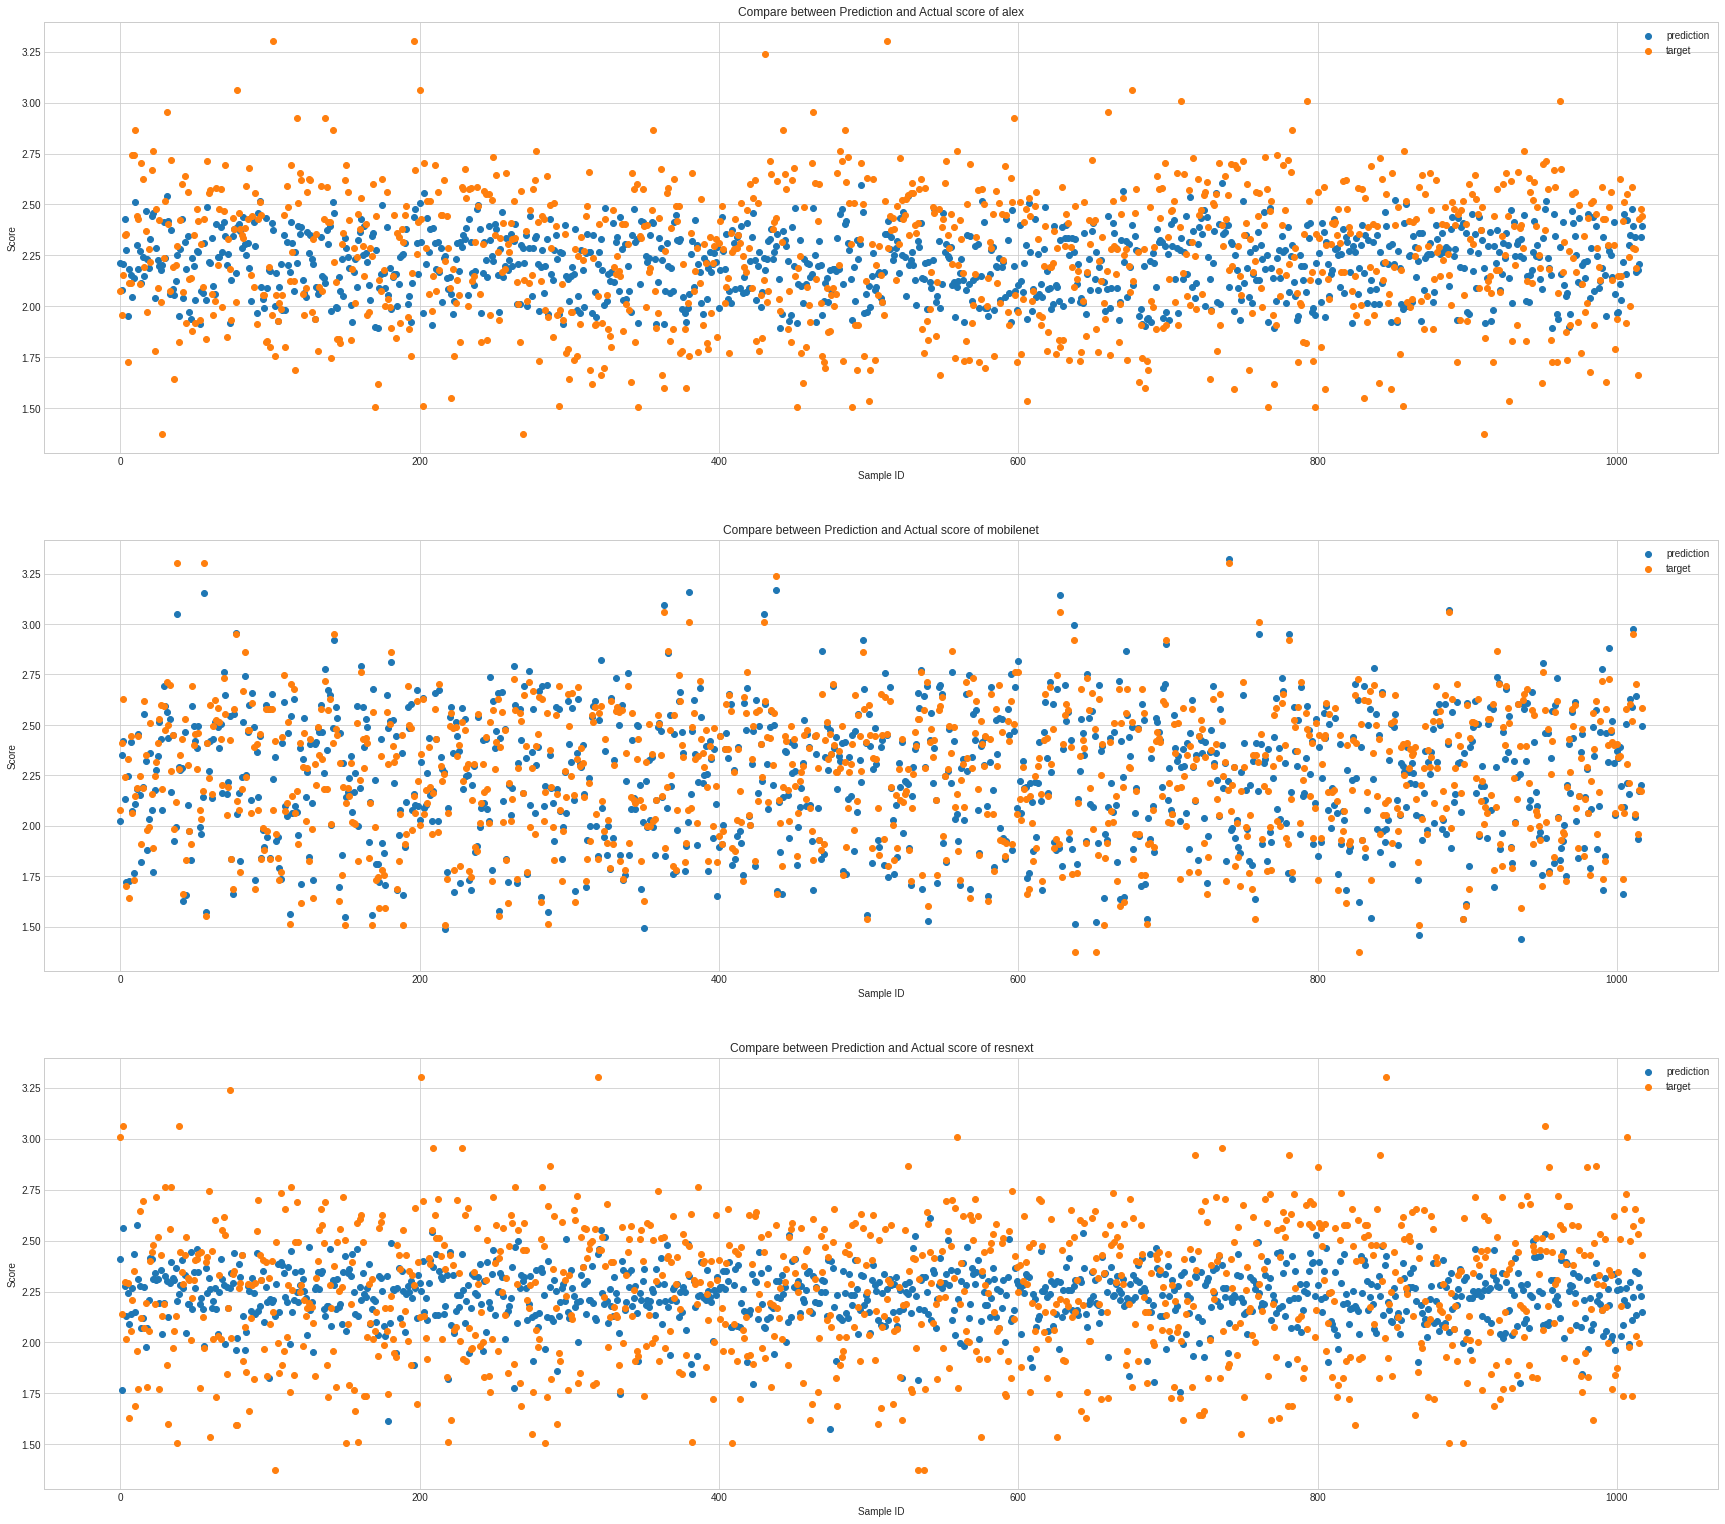

In [5]:
preds_of = dict()
labels_of = dict()
fig,ax = plt.subplots(3, figsize=(30,9*3))
for index, (name, weight) in enumerate(to_do):
    print(name, weight)
    print('='*20)
    model = load_model(name, f'{weight}.pth')
    all_preds, all_labels = predict(model, dataloader, 'cuda:0')
    preds_of[name] = all_preds
    labels_of[name] = all_labels
    ax[index].scatter(np.arange(len(all_preds)),all_preds,label='prediction')
    ax[index].scatter(np.arange(len(all_labels)),all_labels,label='target')
    ax[index].set_title(f'Compare between Prediction and Actual score of {name}')
    ax[index].set_ylabel('Score')
    ax[index].set_xlabel('Sample ID')
    ax[index].legend()
    print_performance(all_preds, all_labels, target)
    print()

plt.show()
del(model)

Top 5 Error example from [alex]
Filename:N415_17_2.JPG
Score Label:3.3010001182556152|Pred:2.440001964569092|diff=0.8609981536865234
Class Label:4|Pred:3


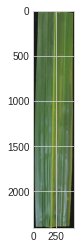

Filename:N345_17_2.JPG
Score Label:1.3760000467300415|Pred:2.286123275756836|diff=0.9101232290267944
Class Label:1|Pred:2


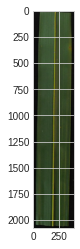

Filename:N363_17_1.JPG
Score Label:3.3010001182556152|Pred:2.374551296234131|diff=0.9264488220214844
Class Label:4|Pred:2


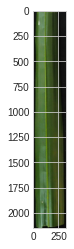

Filename:N60_17_5.JPG
Score Label:3.3010001182556152|Pred:2.3550362586975098|diff=0.9459638595581055
Class Label:4|Pred:2


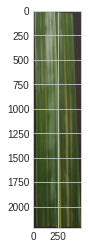

Filename:N336_17_2.JPG
Score Label:3.240000009536743|Pred:2.1776585578918457|diff=1.0623414516448975
Class Label:4|Pred:2


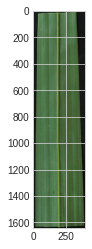

Top 5 Error example from [mobilenet]
Filename:N411_17_4.JPG
Score Label:3.3010001182556152|Pred:3.0488531589508057|diff=0.25214695930480957
Class Label:4|Pred:4


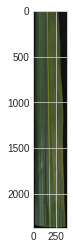

Filename:N177_17_2.JPG
Score Label:2.006999969482422|Pred:2.260441541671753|diff=0.25344157218933105
Class Label:2|Pred:2


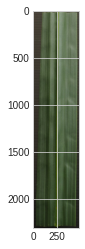

Filename:N406_17_3.JPG
Score Label:2.6540000438690186|Pred:2.3922979831695557|diff=0.2617020606994629
Class Label:3|Pred:2


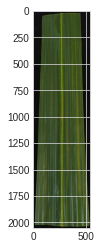

Filename:N172_17_2.JPG
Score Label:1.7359999418258667|Pred:2.025616407394409|diff=0.2896164655685425
Class Label:1|Pred:2


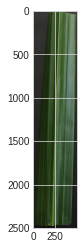

Filename:N234_17_2.JPG
Score Label:2.556999921798706|Pred:2.8661224842071533|diff=0.30912256240844727
Class Label:3|Pred:3


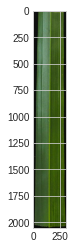

Top 5 Error example from [resnext]
Filename:N397_17_4.JPG
Score Label:3.009999990463257|Pred:2.185636520385742|diff=0.8243634700775146
Class Label:4|Pred:2


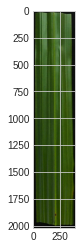

Filename:N167_17_3.JPG
Score Label:3.3010001182556152|Pred:2.434628963470459|diff=0.8663711547851562
Class Label:4|Pred:3


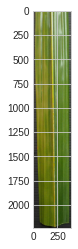

Filename:N374_17_3.JPG
Score Label:3.240000009536743|Pred:2.268625259399414|diff=0.9713747501373291
Class Label:4|Pred:2


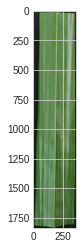

Filename:N261_17_5.JPG
Score Label:3.3010001182556152|Pred:2.250927686691284|diff=1.050072431564331
Class Label:4|Pred:2


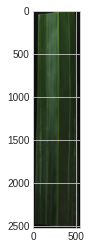

Filename:N325_17_1.JPG
Score Label:3.3010001182556152|Pred:2.4254066944122314|diff=0.8755934238433838
Class Label:4|Pred:3


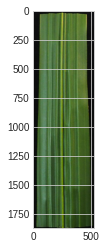

In [6]:
import matplotlib.image as mpimg

for name,_ in to_do:
    print(f"Top 5 Error example from [{name}]")
    print("="*20)
    preds = preds_of[name]
    labels = labels_of[name]
    errors = abs(preds - labels).numpy()
    # get top 5 error  
    idxs = np.argpartition(errors, -5)[-5:]
    for idx in idxs:
        filename = full_dataset.filenames[idx]
        pred = preds[idx]
        label = labels[idx]
        print(f"Filename:{filename}")
        print(f"Score Label:{label}|Pred:{pred}|diff={abs(label-pred)}")
        print(f"Class Label:{get_class(label,target)}|Pred:{get_class(pred,target)}")
        img = mpimg.imread(f'dataset/{sample_set}/{filename}')
        plt.imshow(img)
        plt.show()